In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://### ADD GIT TOKEN ###/mcembalest/teamBlueConduit.git
%cd teamBlueConduit
!pip install .
!pip install -r requirements.txt > /dev/null
%cd gizmo
!pip install -e .

Cloning into 'teamBlueConduit'...
remote: Enumerating objects: 768, done.
remote: Counting objects: 100% (768/768), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 768 (delta 380), reused 542 (delta 210), pack-reused 0
Receiving objects: 100% (768/768), 57.44 MiB | 24.98 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/teamBlueConduit
Processing /content/teamBlueConduit
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for BlueConduitSpatial: filename=BlueConduitSpatial-0.0.0-py3-none-any.whl size=66705 sha256=3e5c6440f795594e0a238f53b0d7d6bb971a853178d97d685141fe9d6be50266
  Stored in directory

## MAKE SURE TO RESTART KERNEL!

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd

from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components#n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)

import io
import pickle
import zipfile

###########
# import our libraries
from blue_conduit_spatial.utilities import *
from blue_conduit_spatial.evaluation import *
from blue_conduit_spatial.distance_matrix import *
from blue_conduit_spatial.modeling.diffusion import ServiceLineDiffusion

LAT_MIN, LAT_MAX = 42.97, 43.09
LON_MIN, LON_MAX = -83.75, -83.62

########### set random state
np.random.seed(297)

In [2]:
!ls '/content/drive/MyDrive/AC297r/Data'

Predictions  Processed	Raw


In [3]:

data_dir = '/content/drive/MyDrive/AC297r/Data'
load_dir = f'{data_dir}/Processed'
pred_dir = f'{data_dir}/Predictions'
pid_lat_lon_path = f'{load_dir}/pid.gpkg'
train_pred_path = f'{pred_dir}/pred_probs_train.npz'
test_pred_path = f'{pred_dir}/pred_probs_test.npz'

Xdata, Ydata, pid, train_idx, test_idx, partitions_builder = load_datasets(load_dir)
train_pred_all, test_pred_all = load_predictions(pred_dir, 'baseline')

In [4]:
# Load data
train_size = 'ts_0.1'
resolution = 'res_47'
split = 0

train_index = train_idx[train_size][resolution][split].values
test_index = test_idx[train_size][resolution][split].values

Xtrain = Xdata.iloc[train_index]
Xtest = Xdata.iloc[test_index]
Ytrain = Ydata.iloc[train_index]['dangerous'].values.astype('float')
Ytest = Ydata.iloc[test_index]['dangerous'].values.astype('float')
train_pred = train_pred_all[train_size][resolution][split]
test_pred = test_pred_all[train_size][resolution][split]
pid_train = pid.iloc[train_index].pid.values
pid_test = pid.iloc[test_index].pid.values
pid_lat_lon_train = pid.iloc[train_index]
pid_lat_lon_test = pid.iloc[test_index]

Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape, pid_train.shape, pid_test.shape

((2354, 301), (19293, 301), (2354,), (19293,), (2354,), (19293,))

In [5]:
# load distance data
# this part is slow
dis_path = f'{load_dir}/road_distances.npz'
distances = np.load(dis_path, allow_pickle=True)

graph = distances['road_distances']
graph[graph==(1.00e+05)]=0.0 #assign invalid 1e5 values to be 0

print('graph', graph.shape)

graph (26857, 26857)


In [6]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import log_loss
from scipy.sparse import csr_matrix
class ServiceLineDiffusion:
    """Note: graph should be a (N, N) numpy array
    
    Args:
        graph (nd.array): (N, N) array
        train_indices (array-like): sequence of indices in graph corresponding
            to the training set
        test_indices (array-like): sequence of indices in graph corresponding
            to the test set
        lat_long_df (pd.DataFrame): if plotting, this will be used to localize
            points on the graph"""
    def __init__(self, graph, train_indices, test_indices, Ytrain, Ytest, Ytrain_pred, Ytest_pred, lam=0.5, lat_long_df=None):
        self.graph = graph
        self.iter_ct = 1
        self.lam = lam

        # Assign overall training and test set indices
        self.train_indices = train_indices
        self.test_indices = test_indices

        # Set up training predictions and baseline prediction probabilities
        self.Ytrain = Ytrain
        self.Ytest = Ytest
        self.Ytest_pred = Ytest_pred
        self.curr_test_pred = self.Ytest_pred.copy() # Initialize 'current' prediction as baseline test
        self.curr_train_pred = Ytrain_pred.copy() # Initialize 'current' prediction as baseline test

        # Set aside separate all_predictions for plotting capabilities
        self.all_predictions = []
        self.lat_long_df = lat_long_df

    def fit(self, n_iter=1, neighbor_fn=None, neighbor_params=None, distance_function=None, verbose=False):

        if (neighbor_params is None) or (neighbor_fn is None):
            self.neighbor_params = {'graph': self.graph, 'K': 5}
            self.neighbor_fn = ServiceLineDiffusion.graph_Kneighbors
        else:
            self.neighbor_params = neighbor_params
            self.neighbor_fn = neighbor_fn

        if distance_function is None:
            self.distance_function = ServiceLineDiffusion.diffusion_distance_weights
        else:
            self.distance_function = distance_function
        
        # To reduce compute time, calculate & store nearest neighbors
        self.neighbor_distances, self.neighbor_idx = self.neighbor_fn(**self.neighbor_params)
        self.neighbor_weights = self.distance_function(self.neighbor_distances)

        # Initialize the lead values & find weighted average of neighbor lead values
        lead_vals = np.array([self._get_lead_value(idx) for idx in range(self.graph.shape[0])]).flatten().astype(float)
        if verbose:
          print(f"Initial Log Loss: {log_loss(self.Ytest, lead_vals[self.test_indices]):0.2f}")

        for i in range(n_iter):
            lead_vals = self.diffusion_step(lead_vals)

            if verbose:
              print(f"Log Loss at Iteration {i+1}: {log_loss(self.Ytest, lead_vals[self.test_indices]):0.2f}")

        # Set current predictions
        self.curr_test_pred = lead_vals[self.test_indices]
        self.curr_train_pred = lead_vals[self.train_indices]
        self.all_predictions = lead_vals
        
        return lead_vals
    
    def predict_proba(self, X, mode=None):
        """Returns probabilities after lead values. Because this is a non-standard "model" and does not
        truly take a new X value, it uses the shape of X to determine whether to return the training
        or test predictions
        
        Args:
            - X (pd.DataFrame, np.array): Array of training or test points, used only for its shape
            - mode (str): One of None, 'train', 'test'. If none, will make decision based on X shape
        
        Returns
            - probs (array): Array of probability of (no lead, lead) in a (N, 2) array to be compliant
        """
        if mode == 'train':
            return np.stack([1-self.curr_train_pred, self.curr_train_pred], axis=1)
        elif mode == 'test':
            return np.stack([1-self.curr_test_pred, self.curr_test_pred], axis=1)
        
        # Utilize shape if not
        if X.shape[0] == len(self.curr_test_pred):
            return self.predict_proba(X, mode='test')
        elif X.shape[0] == len(self.curr_train_pred):
            return self.predict_proba(X, mode='train')
        else:
            raise AttributeError(f'X passed is not of same shape as either training or test predictions.')

    def diffusion_step(self, lead_vals):
        """Takes a single diffusion step. Separated for clean code practices"""
        weighted_avg_neighbor_lead = np.average(lead_vals[self.neighbor_idx], axis=1, weights = self.neighbor_weights)
        lead_vals = np.array([self._update_node(node_val, node_idx, weighted_avg_neighbor_lead, self.lam) for node_idx, node_val in enumerate(lead_vals)])
        lead_vals = lead_vals.flatten()
        return lead_vals
    
    def reset_graph(self):
        """Helper method for removing graph when dealing with memory-intensive methods"""
        self.graph = []

    def _update_node(self, node_val, node_idx, weighted_avg_neighbor_lead, lam=0.5):
        """Defines update step for a single node. Can be overwritten, must return between [0,1]"""
        #if node_val in [0., 1.]:
        #    return node_val
        #else:
        #    return lam * node_val + (1 - lam) * weighted_avg_neighbor_lead[node_idx]
        return lam * node_val + (1 - lam) * weighted_avg_neighbor_lead[node_idx]


    def plot_graph(self, fig, ax, title, colorvals=None, bbox = None):
        """Plotting utility for describing the graph"""

        if colorvals is None:
            colorvals = self.all_predictions

        g = nx.from_numpy_array(self.graph)
        # draw nodes with colors
        graph_pos = {i : self._get_lat_lon(idx) for i, idx in enumerate(subgraph_idx)}
        nx.draw_networkx_nodes(g, graph_pos, node_color=colorvals, vmin=0,vmax=1,cmap = cm.RdYlGn_r, ax=ax)

        # grab edge weights
        all_weights = []
        for (_,_,data) in g.edges(data=True):
            all_weights.append(data['weight'])
        unique_weights = list(set(all_weights))
        
        # draw weights one at a time
        for i, weight in enumerate(unique_weights):
            weighted_edges = np.array([(node1,node2) for (node1,node2,edge_attr) in g.edges(data=True) if edge_attr['weight']==weight])
            alpha = (1 - weight/max(all_weights)) * 0.5
            nx.draw_networkx_edges(g, pos=graph_pos, ax=ax, width=5, edgelist=weighted_edges, alpha = alpha)

        # add color scale
        cb = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap=cm.RdYlGn_r), ax=ax)
        cb.set_label('LEAD value')
        
        ax.set_title(title)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        limits=ax.axis('on')
        if bbox is None:
            ax.set_xlim(LAT_MIN, LAT_MAX)
            ax.set_ylim(LON_MIN, LON_MAX)
        else:
            ax.set_xlim(bbox[0], bbox[1])
            ax.set_ylim(bbox[2], bbox[3])
        
    @staticmethod
    def graph_Kneighbors(graph, K):
        """Gets the nearest neighbors for each node in the graph.
        
        Note: This replaces 0 with 1e7 because sklearn NearestNeighbors treats 0 as
        a valid (close) distance. Since this is a non-connection in our graph, then 
        want it to be a very small weight
        
        Args:
            K (int): Number of neighbors
        Returns:
            neighbor_dist, neighbor_ind : arrays indicating the nearest neighbor and """
        nn = NearestNeighbors(n_neighbors=K, metric='precomputed')
        neighbors_graph = graph.copy()
        neighbors_graph[neighbors_graph==0] = 1e7
        nn.fit(neighbors_graph)
        del neighbors_graph
        return nn.kneighbors()
    
    @staticmethod
    def diffusion_distance_weights(distances):
        """Returns an arbitrary float distance as the inverse for weighting.
        Also adjusts 0 to be 1 such that a distance of zero maps to a weight of 1"""
        return 1/(1 + distances)

    def _get_lat_long(self, idx):
        """Returns latitude and longitude for a given index"""
        return np.array(self.lat_long_df.iloc[idx])

    def _idx2trainidx(self, idx):
        """Returns the specific index within the train data for idx"""
        return np.where(self.train_indices == idx)[0]
    
    def _idx2testidx(self, idx):
        """Returns the specific index within the test data for idx"""
        return np.where(self.test_indices == idx)[0]
    
    def _get_lead_value(self, idx):
        """If the parcel is in the training data, then lead value will be set to
        ground truth. Else, will return the prediction probability"""
        if idx in self.train_indices:
            return self.curr_train_pred[self._idx2trainidx(idx)]
        elif idx in self.test_indices:
            return self.curr_test_pred[self._idx2testidx(idx)]
        else:
            return np.percentile(self.curr_test_pred, 50)


In [7]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=47)

2021-11-03 16:52.44 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 21801.73it/s]

2021-11-03 16:52.46 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-03 16:52.46 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-03 16:52.49 [debug    ] Total parcels after join: 26857
2021-11-03 16:52.49 [info     ] Building the connected graph on the partitions.
2021-11-03 16:52.53 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial Log Loss: 0.30
Log Loss at Iteration 1: 0.26


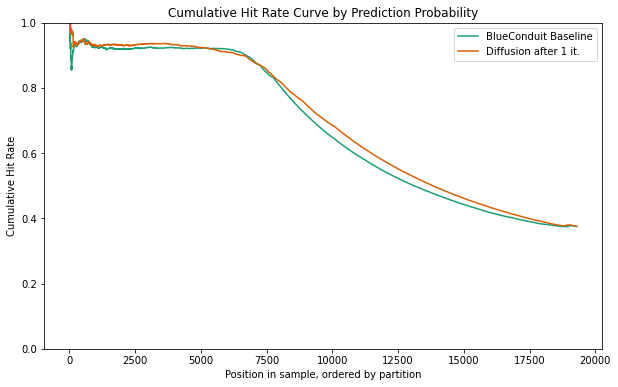

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial Log Loss: 0.26
Log Loss at Iteration 1: 0.28


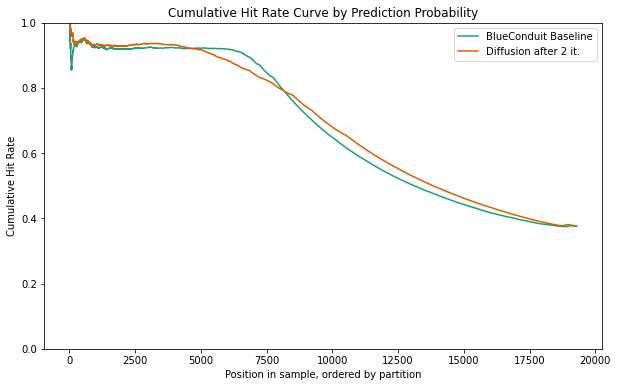

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial Log Loss: 0.28
Log Loss at Iteration 1: 0.30


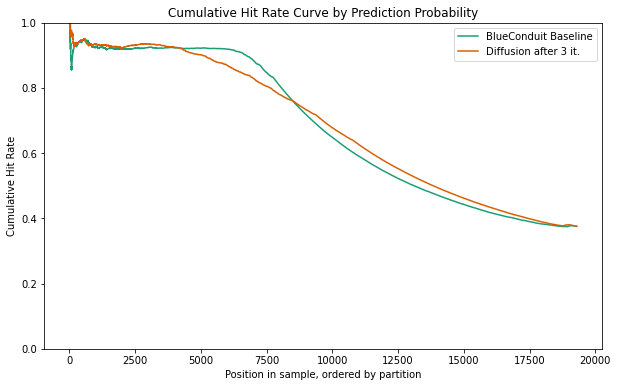

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Initial Log Loss: 0.30
Log Loss at Iteration 1: 0.31
Log Loss at Iteration 2: 0.31
Log Loss at Iteration 3: 0.32
Log Loss at Iteration 4: 0.32
Log Loss at Iteration 5: 0.32


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


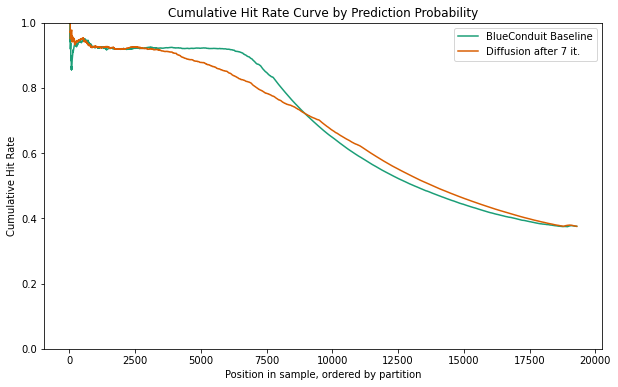

In [ ]:
# Use ServiceLineDiffusion class (i.e. modularized version)
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
for i in range(3):
  out = slg.fit(n_iter=1, verbose=True)
  plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred], plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {i+1} it.'], 
                      mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9)

out = slg.fit(n_iter=5, verbose=True)
plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred], plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {i+5} it.'], 
                    mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9)

## Compare Over Splits

In [41]:
resolutions = [47]
train_sizes = [0.1]
n_iter = 1
plot_dir = '/content/drive/MyDrive/AC297r/Plots/'
!ls '/content/drive/MyDrive/AC297r/Plots'



diffusion


2021-11-03 19:06.29 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 20634.26it/s]

2021-11-03 19:06.31 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-11-03 19:06.31 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-11-03 19:06.34 [debug    ] Total parcels after join: 26857
2021-11-03 19:06.34 [info     ] Building the connected graph on the partitions.
2021-11-03 19:06.37 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory
Working on split 0...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Initial Log Loss: 0.30
Log Loss at Iteration 1: 0.26


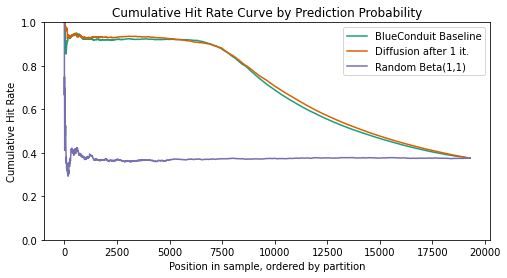

In [46]:
pred_probs_train_dict = {}
pred_probs_test_dict = {}
for i, train_size in enumerate(train_sizes):
  train_probs_pct = {}
  test_probs_pct = {}
  for j, hex_size in enumerate(resolutions):
    train_probs_res = []
    test_probs_res = []
    hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=hex_size)
    for split in range(3):
      if split > 0:
        break
      print(f"Working on split {split}...")
      (train_index, test_index, 
      Xtrain, Xtest, Ytrain, Ytest, 
      train_pred, test_pred) = select_data(Xdata, 
                                            Ydata, 
                                            pid, 
                                            train_idx, 
                                            test_idx, 
                                            train_pred_all, 
                                            test_pred_all,
                                            partitions_builder, 
                                            train_size=train_size,
                                            n_hexagons=hex_size,
                                            split=split, 
                                            generate_hexagons=False)

      slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
      out = slg.fit(n_iter=n_iter, verbose=True)
      plot_hit_rate_curve(Ytest, [test_pred, slg.curr_test_pred, np.random.beta(1, 1, size=len(test_pred))], 
                          plot_probs=False, labels=['BlueConduit Baseline', f'Diffusion after {1} it.', 'Random Beta(1,1)'], 
                          mode='partition', parcel_df=hexagons.parcel_gdf, index_list=test_index, threshold_init=0.9, min_digs=1, threshold_increment=0.1, 
                          figsize=(8,4), savefig=False, figname=f'{n_iter}iter_{train_size}_{hex_size}_{split}.png', figdir=f'{plot_dir}/diffusion/')
      train_preds = slg.curr_train_pred
      train_probs_res.append(train_preds)
                
      test_preds = slg.curr_test_pred
      test_probs_res.append(test_preds)
    train_probs_pct[f'res_{hex_size}'] = np.array(train_probs_res, dtype='object')
    test_probs_pct[f'res_{hex_size}'] = np.array(test_probs_res, dtype='object')

  pred_probs_train_dict[f'ts_{train_size}'] = train_probs_pct
  pred_probs_test_dict[f'ts_{train_size}'] = test_probs_pct

In [ ]:
np.savez(f'{pred_dir}/diffusion_pred_probs_train.npz', **pred_probs_train_dict)
np.savez(f'{pred_dir}/diffusion_pred_probs_test.npz', **pred_probs_test_dict)

## Milestone 2: Figures

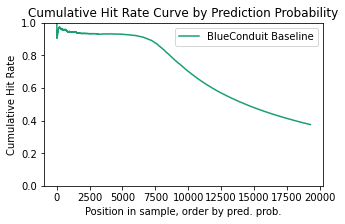

In [ ]:
(train_index, test_index, 
  Xtrain, Xtest, Ytrain, Ytest, 
  train_pred, test_pred) = select_data(Xdata, 
                                        Ydata, 
                                        pid, 
                                        train_idx, 
                                        test_idx, 
                                        train_pred_all, 
                                        test_pred_all,
                                        partitions_builder, 
                                        train_size=train_size,
                                        n_hexagons=hex_size,
                                        split=0, 
                                        generate_hexagons=False)
plot_hit_rate_curve(Ytest, test_pred, plot_probs=False, labels=['BlueConduit Baseline'], mode='all', figsize=(5, 3))

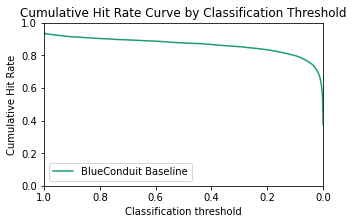

In [ ]:
plot_hit_rate_curve(Ytest, test_pred, plot_probs=False, labels=['BlueConduit Baseline'], mode='all', order_by_prob=True, figsize=(5, 3))

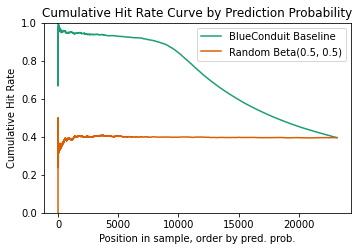

In [ ]:
plot_hit_rate_curve(Ytest, [test_pred, np.random.beta(0.5, 0.5, size=len(test_pred))], plot_probs=False, 
                    labels=['BlueConduit Baseline', 'Random Beta(0.5, 0.5)'], mode='all', figsize=(5.5,3.5))

## Plotting

In [ ]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=47)

2021-10-27 16:51.15 [info     ] Generating the partition map of type 'hexagon'


100%|██████████| 1138/1138 [00:00<00:00, 23618.19it/s]

2021-10-27 16:51.18 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-27 16:51.18 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/content/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-27 16:51.20 [debug    ] Total parcels after join: 26857
2021-10-27 16:51.20 [info     ] Building the connected graph on the partitions.
2021-10-27 16:51.24 [info     ] New Partition dataframe of type 'hexagon' created, using at least 14.37 MB of memory


In [ ]:
def plot_avg_prediction(hexagons, pid, slg, figsize=(16,6), col='output_pred'):
  part_gdf = hexagons.partition_gdf.copy()
  train_df_w_part_id = pid.iloc[train_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
  train_df_w_part_id['output_pred'] = slg.curr_train_pred

  test_df_w_part_id = pid.iloc[test_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
                            
  test_df_w_part_id['output_pred'] = slg.curr_test_pred
  df_w_part_id = train_df_w_part_id.append(test_df_w_part_id)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  part_gdf.merge(right=df_w_part_id.groupby('partition_ID').mean()[col], on='partition_ID').plot(column=col, figsize=(16,6), legend=True, ax=ax)
  ax.set_axis_off()
  plt.show()





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


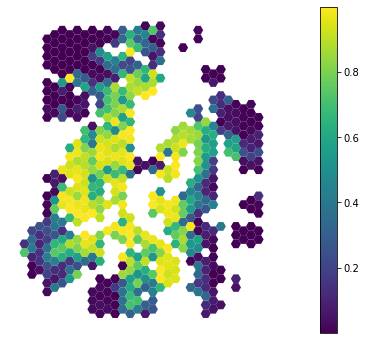

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


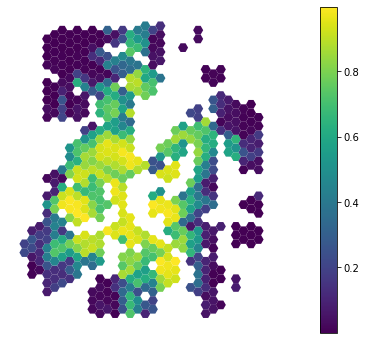

In [ ]:
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
out = slg.fit(n_iter=0, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
out = slg.fit(n_iter=100, verbose=False)
plot_avg_prediction(hexagons, pid, slg)


In [ ]:
def plot_varof_prediction(hexagons, pid, slg, figsize=(16,6), col='output_pred'):
  part_gdf = hexagons.partition_gdf.copy()
  train_df_w_part_id = pid.iloc[train_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
  train_df_w_part_id['output_pred'] = slg.curr_train_pred

  test_df_w_part_id = pid.iloc[test_index].merge(hexagons.parcel_gdf[['parcel_id', 'partition_ID', 'has_lead']].astype(float), 
                            left_on='pid', right_on='parcel_id', how='left').drop(['Latitude', 'Longitude', 'geometry', 'parcel_id'], 
                                                                                   axis=1)
                            
  test_df_w_part_id['output_pred'] = slg.curr_test_pred
  df_w_part_id = train_df_w_part_id.append(test_df_w_part_id)
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  part_gdf.merge(right=df_w_part_id.groupby('partition_ID').std()[col], on='partition_ID').plot(column=col, figsize=(16,6), legend=True, ax=ax)
  ax.set_axis_off()
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


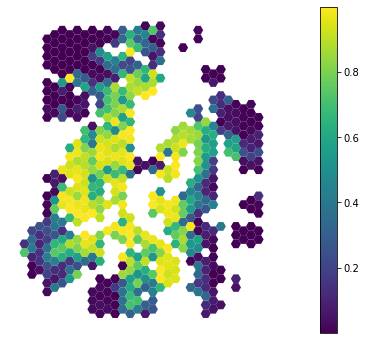

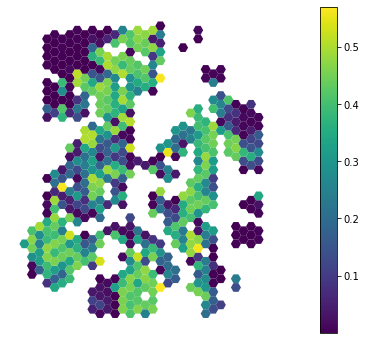

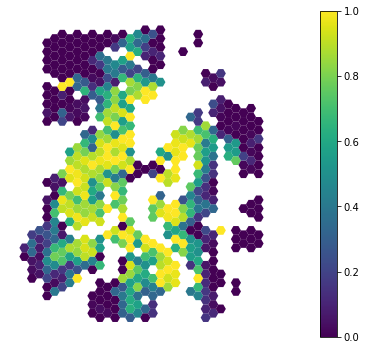

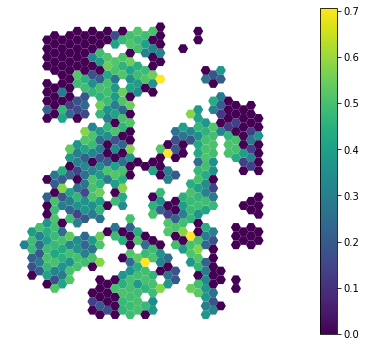

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


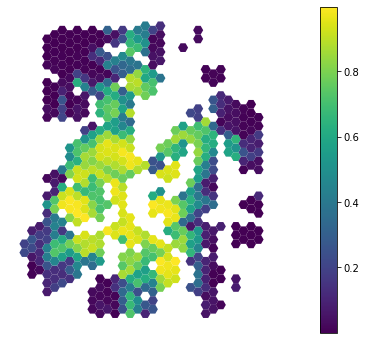

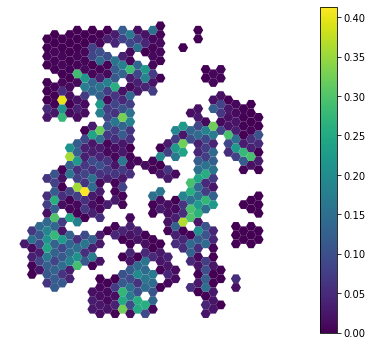

In [ ]:
slg = ServiceLineDiffusion(graph, train_index, test_index, Ytrain, Ytest, train_pred, test_pred)
out = slg.fit(n_iter=0, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
plot_varof_prediction(hexagons, pid, slg)
plot_avg_prediction(hexagons, pid, slg, col='has_lead')
plot_varof_prediction(hexagons, pid, slg, col='has_lead')
out = slg.fit(n_iter=100, verbose=False)
plot_avg_prediction(hexagons, pid, slg)
plot_varof_prediction(hexagons, pid, slg)

In [ ]:
train_idx.keys()

for ts in train_idx.keys():
  print(f"train size: {ts}")
  for res in list(train_idx['ts_0.1'].keys()):
    print(res)
    for i in range(3):
      tr_size = train_idx[ts][res][i].shape[0]
      te_size = test_idx[ts][res][i].shape[0]
      print(tr_size + te_size)

train size: ts_0.1
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.3
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.4
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.6
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.7
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
train size: ts_0.9
res_5
26161
26161
26161
res_10
25585
25585
25585
res_22
24332
24332
24332
res_47
21647
21647
21647
res_99
16490
16490
16490
